In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\johbr\AppData\Local\Temp\ipykernel_8568\138741423.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [4]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [5]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Dropping Neighborhood

In [6]:
df = df[['OverallQual', 'OverallCond', 'GrLivArea', 'TotRmsAbvGrd', 'YearBuilt', 'SalePrice']]
df.head()

,OverallQual,OverallCond,GrLivArea,TotRmsAbvGrd,YearBuilt,SalePrice
0,7,5,1710,8,2003,208500
1,6,8,1262,6,1976,181500
2,7,5,1786,6,2001,223500
3,7,5,1717,7,1915,140000
4,8,5,2198,9,2000,250000


In [7]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]

In [8]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,OverallQual,OverallCond,GrLivArea,TotRmsAbvGrd,YearBuilt,SalePrice
0,7,5,1710,8,2003,208500
1,6,8,1262,6,1976,181500
2,7,5,1786,6,2001,223500
3,7,5,1717,7,1915,140000
4,8,5,2198,9,2000,250000


In [9]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
scaled_df = pd.DataFrame(X_train, columns=dummies.drop(columns="SalePrice").columns)

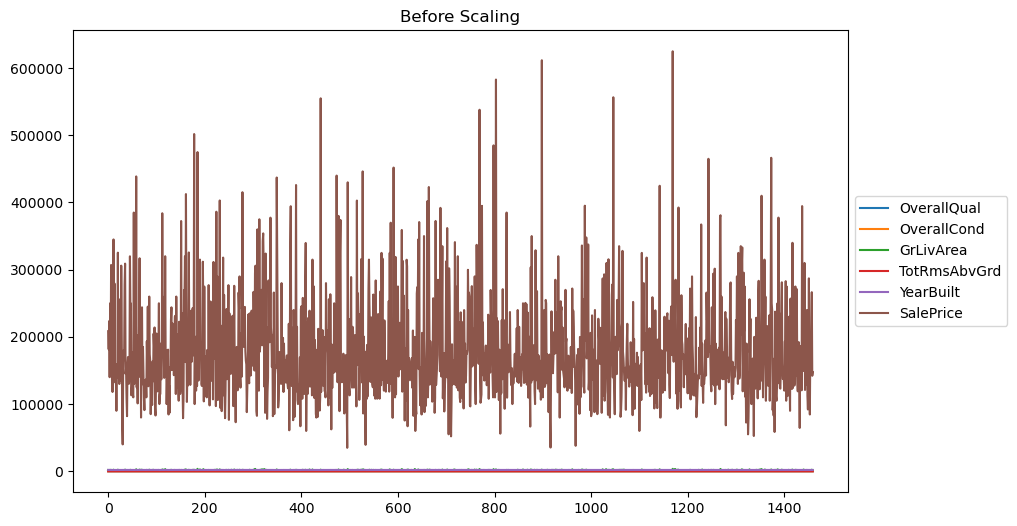

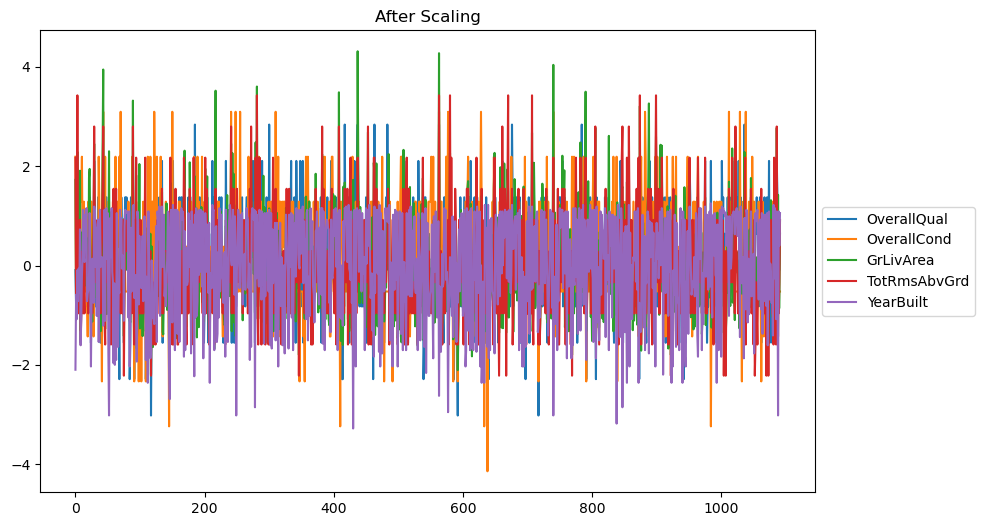

In [10]:
# plot data before scaling
dummies.plot(title='Before Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# after scaling
scaled_df.plot(title='After Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

The outlier is in neighborhood

## Compile, Train, Evaluate the Model

In [11]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=3, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=3, max_value=15, step=2),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [12]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 12s]
mae: 181872.171875

Best mae So Far: 165781.53125
Total elapsed time: 00h 02m 01s


In [13]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 06 summary
Hyperparameters:
num_layers: 2
layer0: 7
activation0: relu
layer1: 11
activation1: LeakyReLU
Score: 165781.53125

Trial 03 summary
Hyperparameters:
num_layers: 2
layer0: 13
activation0: LeakyReLU
layer1: 5
activation1: LeakyReLU
Score: 170374.234375

Trial 09 summary
Hyperparameters:
num_layers: 1
layer0: 15
activation0: relu
layer1: 9
activation1: relu
layer2: 7
activation2: tanh
Score: 181872.171875

Trial 00 summary
Hyperparameters:
num_layers: 2
layer0: 13
activation0: tanh
layer1: 3
activation1: relu
Score: 181980.546875

Trial 05 summary
Hyperparameters:
num_layers: 1
layer0: 13
activation0: tanh
layer1: 15
activation1: LeakyReLU
Score: 182260.09375

Trial 04 summary
Hyperparameters:
num_layers: 1
layer0: 13
activation0: tanh
layer1: 15
activation1: relu
Score: 182260.390625

Trial 07 summary
Hyperparameters:
num_layers: 1
layer0: 11
activation0: tanh
laye

In [14]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hps.values)
print("---")

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Best Hyperparameters:
{'num_layers': 2, 'layer0': 7, 'activation0': 'relu', 'layer1': 11, 'activation1': 'LeakyReLU'}
---


Epoch 1/100
35/35 [==============================] - 1s 7ms/step - loss: 182320.5312 - mae: 182320.5312 - val_loss: 174421.0312 - val_mae: 174421.0312
Epoch 2/100
35/35 [==============================] - 0s 2ms/step - loss: 182319.8594 - mae: 182319.8594 - val_loss: 174420.3125 - val_mae: 174420.3125
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 182319.0000 - mae: 182319.0000 - val_loss: 174419.3594 - val_mae: 174419.3594
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 182317.8594 - mae: 182317.8594 - val_loss: 174418.0781 - val_mae: 174418.0781
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 182316.2344 - mae: 182316.2344 - val_loss: 174416.2344 - val_mae: 174416.2344
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 182313.9688 - mae: 182313.9688 - val_loss: 174413.6875 - val_mae: 174413.6875
Epoch 7/100
35/35 [==============================] - 0s 2ms/step - loss: 182310.8281 - mae: 18

In [15]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 7)                 42        
                                                                 
 dense_3 (Dense)             (None, 11)                88        
                                                                 
 dense_4 (Dense)             (None, 1)                 12        
                                                                 
Total params: 142 (568.00 Byte)
Trainable params: 142 (568.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[-6.004843   5.5706463  4.7395406 -5.45101    5.1608872  5.6238008
   5.194038 ]
 [ 3.1081946  1.1449168 -4.874276   4.336292  -5.6642895 -5.7538643
  -4.131326 ]
 [-5.021794   5.5520773  5.521281  -5.9288325  5.2559915  5.854219
   5.871471 ]
 [-5.847574   4.8164763  5.2415304 -5.428825   4.7111883  4.924552
   5.6913013]
 [-5.3350844  4.121122   5.22222   -5.083257   5.027044   5.2935643
   3.9558961]]
Layer 1 Weights:
[5.7813897 5.751517  5.6133876 5.65267   5.688234  5.6940494 5.7007227]
Layer 2 Weights:
[[ 5.3194733 -6.0946684  5.3127418  6.1224837 -5.360328   5.9184394
   6.1150002  5.541853  -5.86798   -5.3024693 -5.2032323]
 [ 5.2986913 -5.7189384  5.536109   5.6860147 -5.5429893  5.754079
   5.8423066  6.070236  -5.4250665 -5.362275  -5.420424 ]
 [ 5.797828  -6.150873   5.847318   6.0873384 -5.73761    5.8697114
   5.789243   6.106393  -5.729649  -5.758564  -4.921952 ]
 [ 5.2985554 -6.170416   5.6821985  5.4443865 -5.299436   6.3350563
   5.358419   5.676845 

In [17]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

6/6 [==============================] - 0s 2ms/step


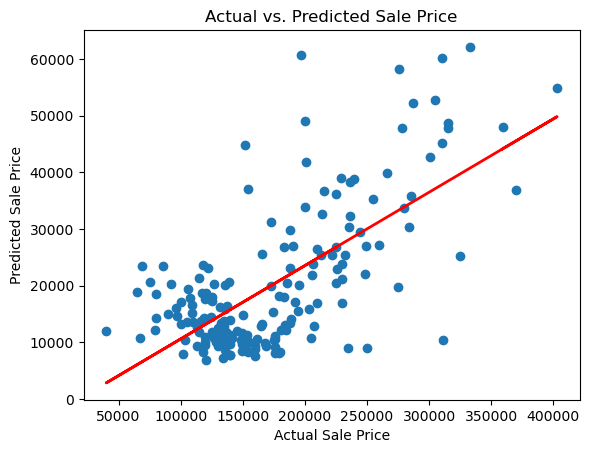

In [18]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [19]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: -5.159491821281478
Mean Squared Error: 26739229016.8809
Mean Absolute Error: 152853.71555470896
Mean Percentage Error: 86.6413959828958


In [20]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -0.020610114208674313
Baseline Mean Squared Error: 4430613494.197803
Baseline Mean Absolute Error: 54345.8021978022
Mean Percentage Error: -21.726878869297774


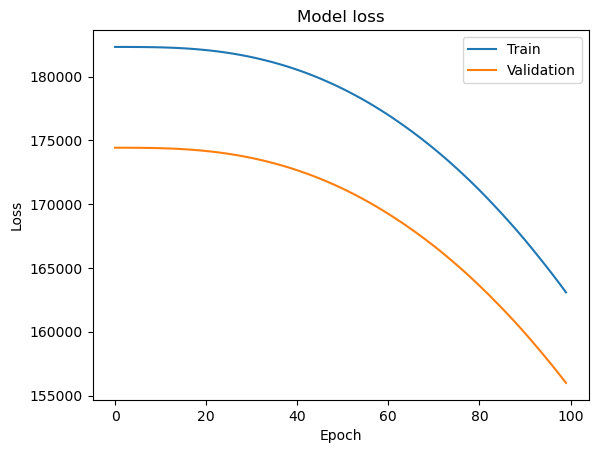

In [21]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

6/6 [==============================] - 0s 1ms/step


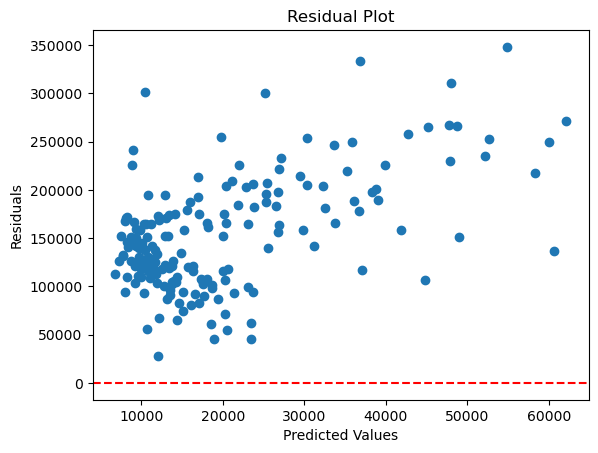

In [22]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

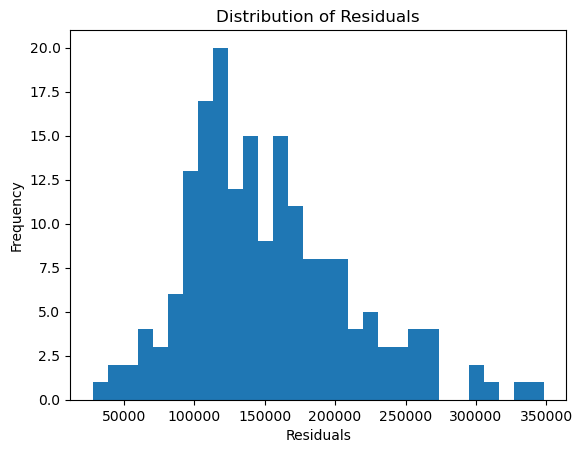

In [23]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [24]:
# plot the learning curve?